In [38]:
import numpy as np
import matplotlib.pyplot as plt

from stacked_mnist import StackedMNISTData, DataMode
from models.vae import VAE
from models.mnist_classifier import MNISTClassifier

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from utils import *

In [39]:
model = VAE(in_channels=3)
model.load_state_dict(torch.load('trained_models/vae_rgb.pt'))
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=256, out_features=128, bias=True)
  )
  (fc_mu): Linear(in_features=128, out_features=16, bias=True)
  (fc_log_var): Linear(in_features=128, out_features=16, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(64, 2, 2))
    (5): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): Con

In [40]:
# Get latent variable
# Using the provided mnist dataset class
gen = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=9)
test_data = gen.get_full_data_set(training=False)

x_test, y_test = test_data

# Convert y_train and y_test into one-hot vectors
y_test = to_one_hot_rgb(y_test)

# Create pytorch dataloaders from x_test and y_test
x_test = torch.from_numpy(x_test.astype(np.float32)).permute(0, 3, 1, 2)
y_test = torch.from_numpy(y_test.astype(np.float32))

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=32)

First, show some reconstructions

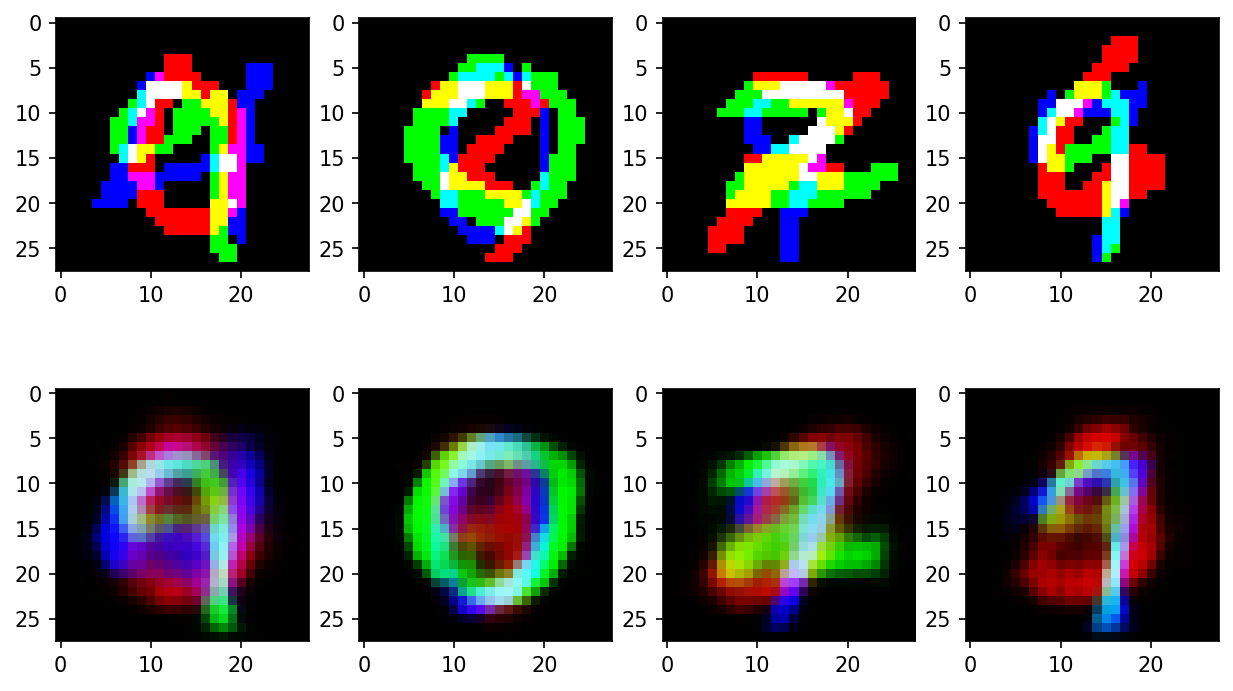

In [41]:
model.eval()

with torch.no_grad():

    x_show, y_show = iter(test_loader).next()

    reconstrustions, _, _ = model(x_show)

    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(2, 4, figsize=(10, 6), dpi=150)

    # Plot each image in a separate subplot
    for i in range(2):
        for j in range(4):
            if i == 0:
                axs[i, j].imshow(x_show[j].permute(1, 2, 0))
            elif i == 1:
                axs[i, j].imshow(reconstrustions[j].permute(1, 2, 0))
        
    plt.show()

Now, let's generate an image

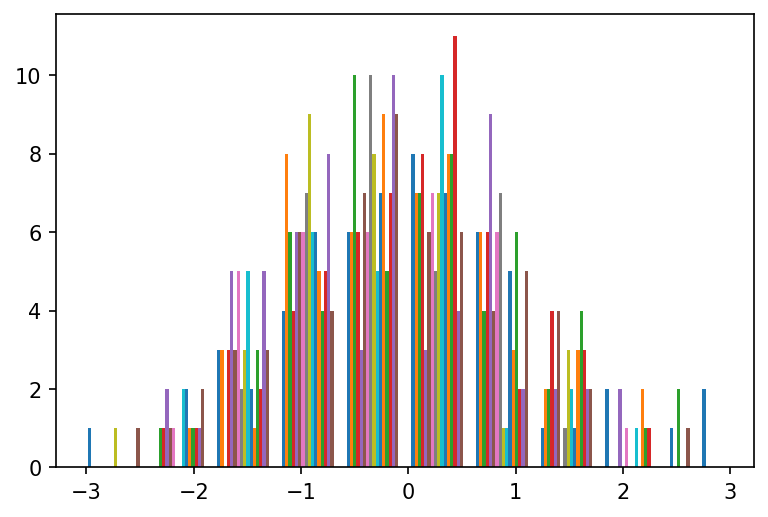

In [42]:
z = torch.normal(0, 1, size=(32, 16))

plt.figure(figsize=(6, 4), dpi=150)
plt.hist(z.detach().numpy())
plt.show()

In [43]:
model.eval()
with torch.no_grad():
    generated_images = model.decoder(z)

In [44]:
generated_images.shape

torch.Size([32, 3, 28, 28])

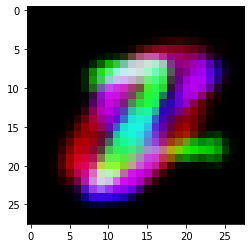

In [45]:
plt.imshow(generated_images[0].permute(1, 2, 0))

In [46]:
model

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=256, out_features=128, bias=True)
  )
  (fc_mu): Linear(in_features=128, out_features=16, bias=True)
  (fc_log_var): Linear(in_features=128, out_features=16, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(64, 2, 2))
    (5): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): Con

In [47]:
z = model.decoder[0:5](z)

c1 = model.decoder[5](z)
c1 = F.relu(c1)

c2 = model.decoder[7](c1)
c2 = F.relu(c2)

c3 = model.decoder[9](c2)
c3 = F.relu(c3)


c4 = model.decoder[11](c3)


c1.shape, c2.shape, c3.shape, c4.shape


(torch.Size([32, 32, 4, 4]),
 torch.Size([32, 16, 7, 7]),
 torch.Size([32, 8, 14, 14]),
 torch.Size([32, 3, 28, 28]))

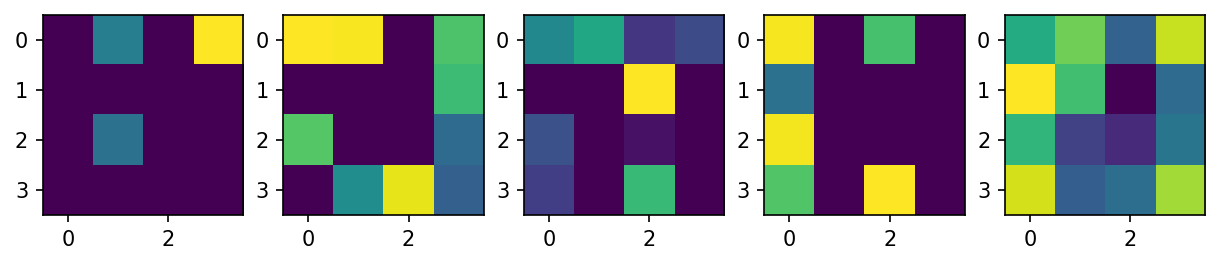

In [48]:
# Visualize som feature maps from c1
with torch.no_grad():
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(1, 5, figsize=(10, 6), dpi=150)

    # Plot each image in a separate subplot
    for i in range(5):
        axs[i].imshow(c1[0][i])
        
    plt.show()

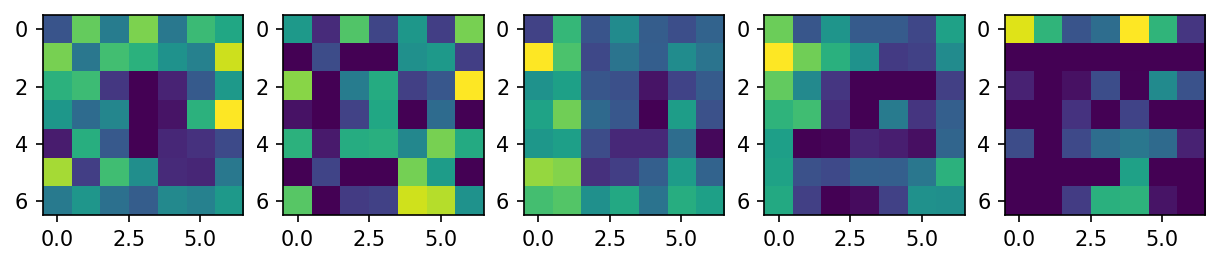

In [49]:
with torch.no_grad():
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(1, 5, figsize=(10, 6), dpi=150)

    # Plot each image in a separate subplot
    for i in range(5):
        axs[i].imshow(c2[0][i])
        
    plt.show()

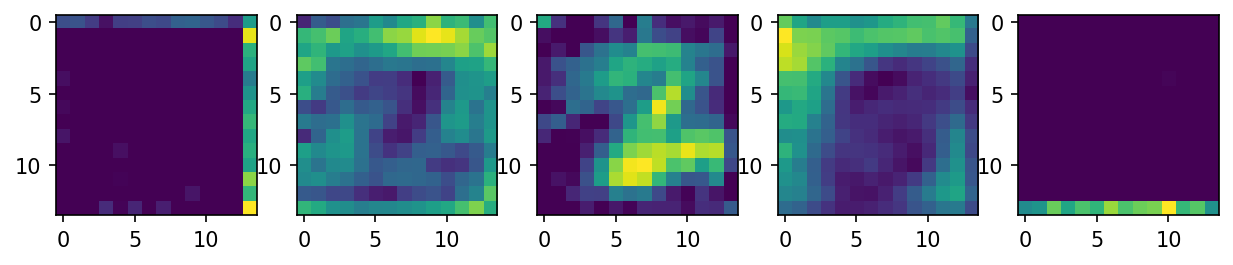

In [50]:
with torch.no_grad():
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(1, 5, figsize=(10, 6), dpi=150)

    # Plot each image in a separate subplot
    for i in range(5):
        axs[i].imshow(c3[0][i])
        
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


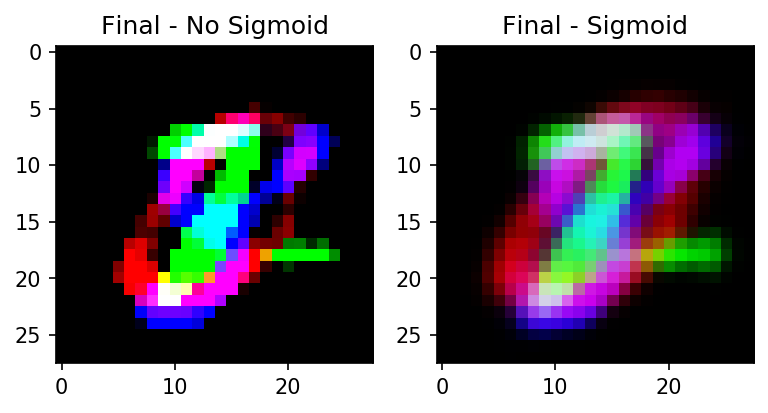

In [51]:
with torch.no_grad():    
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(1, 2, figsize=(6, 4), dpi=150)

    # Plot each image in a separate subplot
    axs[0].imshow(c4[0].permute(1, 2, 0))
    axs[0].set_title('Final - No Sigmoid')
    axs[1].imshow(F.sigmoid(c4[0]).permute(1, 2, 0))
    axs[1].set_title('Final - Sigmoid')

        
    plt.show()

Some more generated images

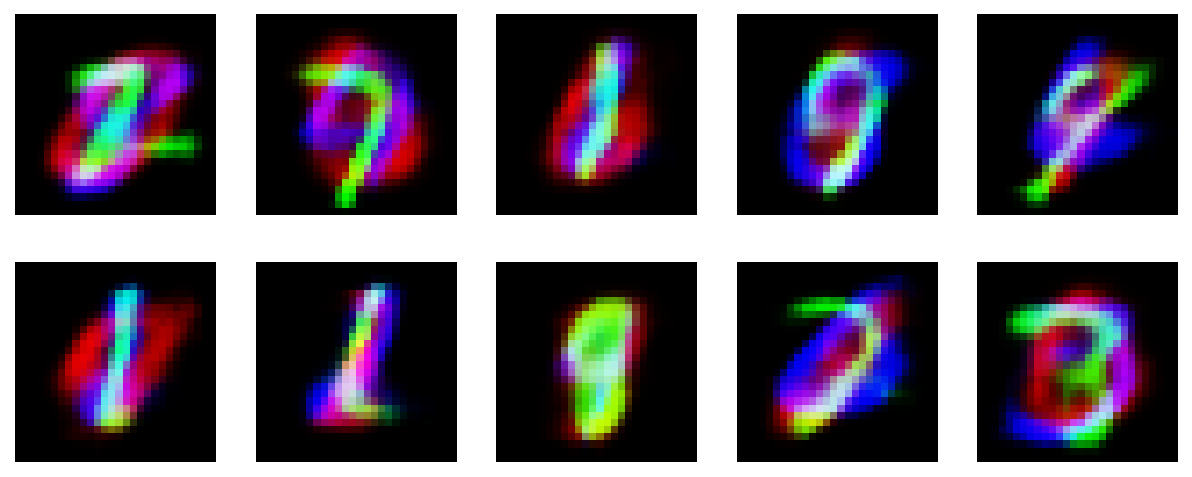

In [52]:
with torch.no_grad():    
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(2, 5, figsize=(10, 4), dpi=150)

    n = 0
    for i in range(2):
        for j in range(5):
            axs[i, j].imshow(generated_images[n].permute(1, 2, 0))
            axs[i, j].axis("off")
            n += 1

        
    plt.show()